In [1]:
import pandas as pd
import numpy as np
import struct
import os
import matplotlib.pyplot as plt

In [2]:
# open file
fname = os.path.abspath(os.getcwd()) + "/STDF_data/main_Lot_1_Wafer_1_Oct_13_09h33m41s_STDF.stdf"

In [3]:
with open(fname,mode='rb') as file:
    row_data = file.read()
#str_row_data=str(row_data)
row_data

b'\x02\x00\x00\n\x02\x04y\x00\x00\x14\xf8T\xffWtdataformatter tester config; Ver: SmarTest s/w rev. 7.1.4.3 (E), 15-Oct-12; dataformatter 2.0.9 Oct 15 2012 18:37:15\x82\x00\x01\n\xeaT\xffW\xf8T\xffW\x01 N \xff\xff \x011\x00\x15localhost.localdomain\t93000-SOC\x05cp_32\x00\x00\x07vincent\x0593000 s/w rev. 7.1.4.3 (E), 15-Oct-12\n\x00\x0525.25\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14\x00\x01P\x01\x02\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x12\x00\x01<\x01\x00\x01\x00\x03Xin\x0510101\x011\x01\x01\x13\x00\x01<\x02\x00\x02\x00\x04Xout\x0510102\x012\x01\x01\x0e\x00\x01<\x03\x00\x00\x00\x03VCC\x0211\x00\x01\x01\x14\x00\x02\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x00\x80\x00\x80  \x07\x00\x02\n\x01\x02\xf8T\xffW\x00\x02\x00\x05\n\x01\x01\x12\x00\x01<\x01\x00\x01\x00\x03Xin\x0510101\x011\x01\x01\x13\x00\x01<\x02\x00\x02\x00\x04Xout\x0510102\x012\x01\x01\x0e\x00\x01<\x03\x00\x00\x00\x03VCC\x0211\x00\x01\x01\x1a\

# Filter Method

In [4]:
dict_pack = {
    'FAR':[0,10],
    'ATR':[0,20],
    'MIR':[1,10],
    'MRR':[1,20],
    'PCR':[1,30],
    'HBR':[1,40],
    'SBR':[1,50],
    'PMR':[1,60],
    'PGR':[1,62],
    'PLR':[1,63],
    'RDR':[1,70],
    'SDR':[1,80],
    'WIR':[2,10],
    'WRR':[2,20],
    'WCR':[2,30],
    'PIR':[5,10],
    'PRR':[5,20],
    'TSR':[10,30],
    'PTR':[15,10],
    'MPR':[15,15],
    'FTR':[15,20],
    'BPS':[20,10],
    'EPS':[20,20],
    'GDR':[50,10],
    'DTR':[50,30]
}
#dict_pack['PRR'][0]

In [5]:
def struct_packing(rtype,subtype):
    packing = str(struct.pack("BB",rtype,subtype))
    return packing[2:len(packing)-1]

def data_mark(string_row_data,key_header,key):
    key_list = string_row_data.split(key_header)    #will cut key_header

    for n in range(0,len(dict_position[key])):
        if dict_position[key][n][1]==1:            
            key_list[n] = key_list[n][:len(key_list[n])-8] + "|" + key_list[n][len(key_list[n])-8:]
            key_list[n] = key_list[n]+"%"+key+":"+key_header
        else:
            key_list[n] = key_list[n]+key_header
    
    return "%".join(key_list)


def debug_by_positionrule_2():
    #/need execute before data_marking/
    #position locate
    dict_position = {}

    for key in dict_pack.keys():
        header = struct_packing(dict_pack[key][0],dict_pack[key][1])
        group_list = str_row_data.split(header)
        group_count = 0
        dict_position[key]=[]
        for num in range(0, len(group_list)-1):
            group_count = group_count + len(group_list[num])
            add_group = [group_count,1]
            dict_position[key].append(add_group)
    
    #ATR:bewteen FAR,MIR
    if dict_position['ATR'][0][0] < dict_position['ATR'][1][0]:
        dict_position['ATR'][1][1]=0
    #MRR:need last
    elif dict_position['MRR'][0][0] < dict_position['MRR'][1][0]:
        dict_position['MRR'][0][1]=0
    #SBR:after HBR
    for l in dict_position['SBR']:
        if l[0] < dict_position['HBR'][0][0]:
            l[1]=0
    #PIR:after PRR
    for l in dict_position['PIR']:
        if l[0] < dict_position['PRR'][0][0]:
            l[1]=0
    
    return dict_position


def extract_data(processed_data):
    record_type_split = processed_data.split("|")
    for data in range(1,len(record_type_split)):
        data_extracted = record_type_split[data].split("%")
    return data_extracted



# execute

In [6]:
# read binary data
with open(fname,mode='rb') as file:
    row_data = file.read()
str_row_data=str(row_data)

dict_position = debug_by_positionrule_2()

# data mark
processed_data = str_row_data
for num_key in range(0,25):
    key = list(dict_pack.keys())[num_key]
    header = struct_packing(dict_pack[key][0],dict_pack[key][1])
    processed_data = data_mark(processed_data,header,key)
processed_data

"b'|\\x02\\x00%FAR:\\x00\\n%\\x02\\|x04y\\x00%ATR:\\x00\\x14%\\xf8T\\xffWtdataformatter tester config; Ver: SmarTest s/w rev. 7.1.4.3 (E), 15-Oct-12; dataformatter 2.0.9 Oct 15 2012 18:37:15|\\x82\\x00%MIR:\\x01\\n%\\xeaT\\xffW\\xf8T\\xffW\\x01 N \\xff\\xff \\x011\\x00\\x15localhost.localdomain\\t93000-SOC\\x05cp_32\\x00\\x00\\x07vincent\\x0593000 s/w rev. 7.1.4.3 (E), |15-Oct-1%GDR:2\\n%\\x00\\x0525.25\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\|x14%\\x00%SDR:\\x01P%\\x01\\x02\\x01\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00|\\x12\\x00%PMR:\\x01<%\\x01\\x00\\x01\\x00\\x03Xin\\x0510101\\x011\\x01\\x01|\\x13\\x00%PMR:\\x01<%\\x02\\x00\\x02\\x00\\x04Xout\\x0510102\\x012%\\x01\\x01|\\x0e\\x00%PMR:\\x01<%\\x03\\x00\\x00\\x00\\x03VCC\\x0211|\\x00\\x01%MRR:\\x01\\|x14%\\x00|%WCR:\\x0%DTR:2\\x1e%%\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00 \\x00\\x80\\x00\\x80  |\\x07\\x00|%WIR:\\x0%

In [7]:
#check data integrity
record_type_split = processed_data.split("|")
for data in range(1,len(record_type_split)):
    data_extracted = record_type_split[data].split("%")
    print(len(data_extracted),data_extracted)

3 ['\\x02\\x00', 'FAR:\\x00\\n', '\\x02\\']
3 ['x04y\\x00', 'ATR:\\x00\\x14', '\\xf8T\\xffWtdataformatter tester config; Ver: SmarTest s/w rev. 7.1.4.3 (E), 15-Oct-12; dataformatter 2.0.9 Oct 15 2012 18:37:15']
3 ['\\x82\\x00', 'MIR:\\x01\\n', '\\xeaT\\xffW\\xf8T\\xffW\\x01 N \\xff\\xff \\x011\\x00\\x15localhost.localdomain\\t93000-SOC\\x05cp_32\\x00\\x00\\x07vincent\\x0593000 s/w rev. 7.1.4.3 (E), ']
3 ['15-Oct-1', 'GDR:2\\n', '\\x00\\x0525.25\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\']
4 ['x14', '\\x00', 'SDR:\\x01P', '\\x01\\x02\\x01\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00']
3 ['\\x12\\x00', 'PMR:\\x01<', '\\x01\\x00\\x01\\x00\\x03Xin\\x0510101\\x011\\x01\\x01']
4 ['\\x13\\x00', 'PMR:\\x01<', '\\x02\\x00\\x02\\x00\\x04Xout\\x0510102\\x012', '\\x01\\x01']
3 ['\\x0e\\x00', 'PMR:\\x01<', '\\x03\\x00\\x00\\x00\\x03VCC\\x0211']
2 ['\\x00\\x01', 'MRR:\\x01\\']
2 ['x14', '\\x00']
5 ['', 'WCR:\\x0

In [8]:
head_part = []
record_type = []
body_part = []
missing_data = []

record_type_split = processed_data.split("|")
for data in range(1,len(record_type_split)):
    data_extracted = record_type_split[data].split("%")
        
    if len(data_extracted) == 3:
        head_part.append(data_extracted[0])
        record_type.append(data_extracted[1].split(":")[0])
        body_part.append(data_extracted[2])
    elif len(data_extracted) == 4:
        head_part.append(data_extracted[0])
        record_type.append(data_extracted[1].split(":")[0])
        body_part.append(data_extracted[2]+data_extracted[3])
    else:
        missing_data.append(data_extracted)       
        
print("h",head_part)
print("\nr",record_type)
print("\nb",body_part)
print("\nm",missing_data)

print(len(head_part))
print(len(record_type))
print(len(body_part))

h ['\\x02\\x00', 'x04y\\x00', '\\x82\\x00', '15-Oct-1', 'x14', '\\x12\\x00', '\\x13\\x00', '\\x0e\\x00', '\\x12\\x00', '\\x13\\x00', '\\x0e\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1a\\x00', '\\x02\\x00', '\\x1b\\x00', '\\x02\\x00', '\\x1b\\x00', '\\x02\\x00', '\\x1b\\x00', '\\x02\\x00', '\\x1b\\x00', 'x00 \\x00', '\\x0e\\x00', '\\x0e\\x00', '\\x0e\\x00', '\\x0e\\x00', '\\x16\\x00', '\\x16\\x00', '\\x07\\x00']

r ['FAR', 'ATR', 'MIR', 'GDR', '\\x00', 'PMR', 'PMR', 'PMR', 'PMR', 'PMR', 'PMR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'PIR', 'PRR', 'WRR', 'HBR', 'HBR', 'SBR', 'SBR', 'PCR', 'PCR', 'MRR']

b ['\\x02\\', '\\xf8T\\xffWtdataformatter tester config; Ver: SmarTest s/w re

In [9]:
zip_data = zip(head_part,record_type,body_part)
zip_data
#list_data = list(zip_data)

In [10]:
df = pd.DataFrame(columns=['head_part','record_type','body_part'])
df['head_part'] = head_part
df['record_type'] = record_type
df['body_part'] = body_part
df

,head_part,record_type,body_part
0,\x02\x00,FAR,\x02\
1,x04y\x00,ATR,\xf8T\xffWtdataformatter tester config; Ver: S...
2,\x82\x00,MIR,\xeaT\xffW\xf8T\xffW\x01 N \xff\xff \x011\x00\...
3,15-Oct-1,GDR,\x00\x0525.25\x00\x00\x00\x00\x00\x00\x00\x00\...
4,x14,\x00,SDR:\x01P\x01\x02\x01\x01\x00\x00\x00\x00\x00\...
5,\x12\x00,PMR,\x01\x00\x01\x00\x03Xin\x0510101\x011\x01\x01
6,\x13\x00,PMR,\x02\x00\x02\x00\x04Xout\x0510102\x012\x01\x01
7,\x0e\x00,PMR,\x03\x00\x00\x00\x03VCC\x0211
8,\x12\x00,PMR,\x01\x00\x01\x00\x03Xin\x0510101\x011\x01\x01
9,\x13\x00,PMR,\x02\x00\x02\x00\x04Xout\x0510102\x012\x01\x01


### str 轉回 binary 出現問題
剪貼簿暫解

In [11]:
filter = df['record_type']=='PRR'
n=0
for line in df[filter].body_part:
    n += 1
    print(line)
print(n)

\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfb\xff\xfc\xff\x03\x02\x00\x00\x011\x050.000\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\xff\xff\xfc\xff\x01\x00\x00\x00\x012\x051.750\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x04\x00\xfc\xff\x01\x00\x00\x00\x013\x052.201\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x06\x00\xfc\xff\x01\x00\x00\x00\x014\x052.803\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x07\x00\xfc\xff\x01\x00\x00\x00\x015\x052.547\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\xf9\xff\xfd\xff\x01\x00\x00\x00\x016\x052.702\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfd\xff\xfd\xff\x01\x00\x00\x00\x017\x052.700\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfe\xff\xfd\xff\x01\x00\x00\x00\x018\x052.101\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x03\x00\xfd\xff\x01\x00\x00\x00\x019\x052.600\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x04\x00\xfd\xff\x01\x00\x00\x00\x0210\x052.765\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\x06\x00\xfd\xff\x01\x00\x00\x00\x0211\x052.704\x00
\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfa\

In [12]:
p1="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfb\xff\xfc\xff\x03\x02\x00\x00\x011\x050.000\x00"
p2="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xff\xff\xfc\xff\x01\x00\x00\x00\x012\x051.750\x00"
p3="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x04\x00\xfc\xff\x01\x00\x00\x00\x013\x052.201\x00"
p4="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x06\x00\xfc\xff\x01\x00\x00\x00\x014\x052.803\x00"
p5="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x07\x00\xfc\xff\x01\x00\x00\x00\x015\x052.547\x00"
p6="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xf9\xff\xfd\xff\x01\x00\x00\x00\x016\x052.702\x00"
p7="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfd\xff\xfd\xff\x01\x00\x00\x00\x017\x052.700\x00"
p8="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfe\xff\xfd\xff\x01\x00\x00\x00\x018\x052.101\x00"
p9="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x03\x00\xfd\xff\x01\x00\x00\x00\x019\x052.600\x00"
p10="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x04\x00\xfd\xff\x01\x00\x00\x00\x0210\x052.765\x00"
p11="\x01\x01\x00\x00\x00\x01\x00\x01\x00\x06\x00\xfd\xff\x01\x00\x00\x00\x0211\x052.704\x00"
p12="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfa\xff\x00\x00\x01\x00\x00\x00\x0212\x052.802\x00"
p13="\x01\x01\x00\x00\x00\x01\x00\x01\x00\xfc\xff\x00\x00\x01\x00\x00\x00\x0213\x052.304\x00"

p_list = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13]
prr = ['U1','U1','B1','U2','U2','U2','I2','I2','U4','Cn','Cn','Bn']
prr_head = ['head_num','site_num','part_flg','num_test','hard_bin','soft_bin','x_coord','y_coord','test_t','part_id','part_txt','part_fix']
fmt = "<BBBHHHhhL"

head_num = []
site_num = []
part_flg = []
num_test = []
hard_bin = []
soft_bin = []
x_coord = []
y_coord = []
test_t = []
part_id = []
part_txt = []
part_fix = []

df = pd.DataFrame(columns=prr_head)

for p in p_list:
    data = p.encode("latin1")
    dec = struct.unpack(fmt,data[:17])
    dec_data = [*dec,]
    dec_data.append(data[18:19].decode())
    dec_data.append(data[20:25].decode())
    dec_data.append([])

    head_num.append(dec_data[0])
    site_num.append(dec_data[1])
    part_flg.append(dec_data[2])
    num_test.append(dec_data[3])
    hard_bin.append(dec_data[4])
    soft_bin.append(dec_data[5])
    x_coord.append(dec_data[6])
    y_coord.append(dec_data[7])
    test_t.append(dec_data[8])
    part_id.append(dec_data[9])
    part_txt.append(dec_data[10])
    part_fix.append(dec_data[11])

print(len(head_num))
print(len(site_num))

df['head_num']=head_num
df['site_num']=site_num
df['part_flg']=part_flg
df['num_test']=num_test
df['hard_bin']=hard_bin
df['soft_bin']=soft_bin
df['x_coord']=x_coord
df['y_coord']=y_coord
df['test_t']=test_t
df['part_id']=part_id
df['part_txt']=part_txt
df['part_fix']=part_fix

df

13
13


,head_num,site_num,part_flg,num_test,hard_bin,soft_bin,x_coord,y_coord,test_t,part_id,part_txt,part_fix
0,1,1,0,0,1,1,-5,-4,515,1,0.000,[]
1,1,1,0,0,1,1,-1,-4,1,2,1.750,[]
2,1,1,0,0,1,1,4,-4,1,3,2.201,[]
3,1,1,0,0,1,1,6,-4,1,4,2.803,[]
4,1,1,0,0,1,1,7,-4,1,5,2.547,[]
5,1,1,0,0,1,1,-7,-3,1,6,2.702,[]
6,1,1,0,0,1,1,-3,-3,1,7,2.700,[]
7,1,1,0,0,1,1,-2,-3,1,8,2.101,[]
8,1,1,0,0,1,1,3,-3,1,9,2.600,[]
9,1,1,0,0,1,1,4,-3,1,1,2.76,[]


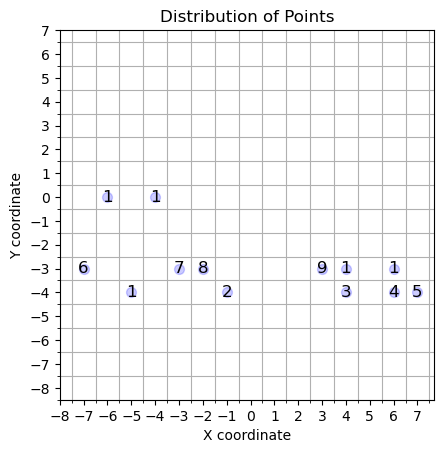

In [13]:
## Visualization

#data list
x=df["x_coord"]
y=df["y_coord"]
id=df["part_id"]

# plt setting
fig = plt.figure() 
ax = fig.add_subplot(1, 1, 1) 

plt.title("Distribution of Points")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")

#scatter plot
ax.scatter(x, y, color="blue", s=50, marker="o", alpha=0.2)

#show id on grapg
for i in range(len(x)):
    plt.annotate(id[i], xy=(x[i], y[i]), color="black", size=12, ha="center", va="center")

#add grid
ax.set_yticks(np.arange(-8,8,1))
ax.set_yticks(np.arange(-8,8,1)-0.5, minor=True)

ax.set_xticks(np.arange(-8,8,1))
ax.set_xticks(np.arange(-8,8,1)+0.5, minor=True)
ax.grid(True, which="minor")
ax.set_aspect("equal")

plt.show()